In [1]:
import torch
import torch.nn as nn
#import find_mxnet
import mxnet as mx
import importlib
import numpy as np



In [2]:
## ------------------------ 3D CNN module ---------------------- ##
def conv3D_output_size(img_size, padding, kernel_size, stride):
#     print("Image size is ",img_size)
    # compute output shape of conv3D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int),
                np.floor((img_size[2] + 2 * padding[2] - (kernel_size[2] - 1) - 1) / stride[1] + 1).astype(int))
#     print("The output shape is ",outshape)           
    return outshape

class CNN3D(nn.Module):
    def __init__(self, t_dim=10, img_x=128, img_y=128, drop_p=0.2, fc_hidden1=256, fc_hidden2=128, num_classes=2):
        super(CNN3D, self).__init__()

        # set video dimension
        self.t_dim = t_dim
        self.img_x = img_x
        self.img_y = img_y
        # fully connected layer hidden nodes
        self.fc_hidden1, self.fc_hidden2 = fc_hidden1, fc_hidden2
        self.drop_p = drop_p
        self.num_classes = num_classes
        self.ch1, self.ch2 = 32, 48
        self.k1, self.k2 = (1, 3, 3), (1, 3, 3)  # 3d kernel size
        self.s1, self.s2 = (1, 1, 1), (1, 1, 1)  # 3d strides
        self.pd1, self.pd2 = (0, 0, 0), (0, 0, 0)  # 3d padding

        # compute conv1 & conv2 output shape
        self.conv1_outshape = conv3D_output_size((3, self.img_x, self.img_y), self.pd1, self.k1, self.s1)
        self.conv2_outshape = conv3D_output_size(self.conv1_outshape, self.pd2, self.k2, self.s2)

        self.conv1 = nn.Conv3d(in_channels=10, out_channels=self.ch1, kernel_size=self.k1, stride=self.s1,
                               padding=self.pd1)
        self.bn1 = nn.BatchNorm3d(self.ch1)
        self.conv2 = nn.Conv3d(in_channels=self.ch1, out_channels=self.ch2, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2)
        self.bn2 = nn.BatchNorm3d(self.ch2)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout3d(self.drop_p)
        self.pool = nn.MaxPool3d((1,2,2))
        #Combining into linear layers now
        
        
        self.fc1 = nn.Linear(self.ch2 * self.conv2_outshape[0] * self.conv2_outshape[1]* self.conv2_outshape[2], self.fc_hidden1)  #* self.conv2_outshape[2],
                              # fully connected hidden layer
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.fc3 = nn.Linear(self.fc_hidden2, self.num_classes)  # fully connected layer, output = multi-classes
        

    def forward(self, x_3d):
        # Conv 1
        #print(x_3d.shape)
        x_3d = x_3d.type(torch.cuda.FloatTensor)
        x_3d = x_3d.permute(0,1,4,2,3)
        #Permuting shape so that it matches the format for conv3D
        #print(x_3d.shape)
        #print(self.conv1)
        x = self.conv1(x_3d)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop(x)
        
        # Conv 2
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop(x)
        # FC 1 and 2
        #print("Fully connected ",x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.drop_p, training=self.training)
        x = self.fc3(x)

        return x


In [3]:

%matplotlib inline
from graphviz import Digraph
import re
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models


def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                value = '('+(', ').join(['%d'% v for v in var.size()])+')'
                dot.node(str(id(var)), str(value), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
    add_nodes(var.grad_fn)
    return dot


inputs = torch.randn(1,10,128,128,3)
resnet18 = CNN3D().cuda()
y = resnet18(Variable(inputs))
print(y)
# g = make_dot(y)
make_dot(y)


tensor([[-0.0388,  0.0017]], device='cuda:0', grad_fn=<ThAddmmBackward>)


In [ ]:
print(torch.__version__)

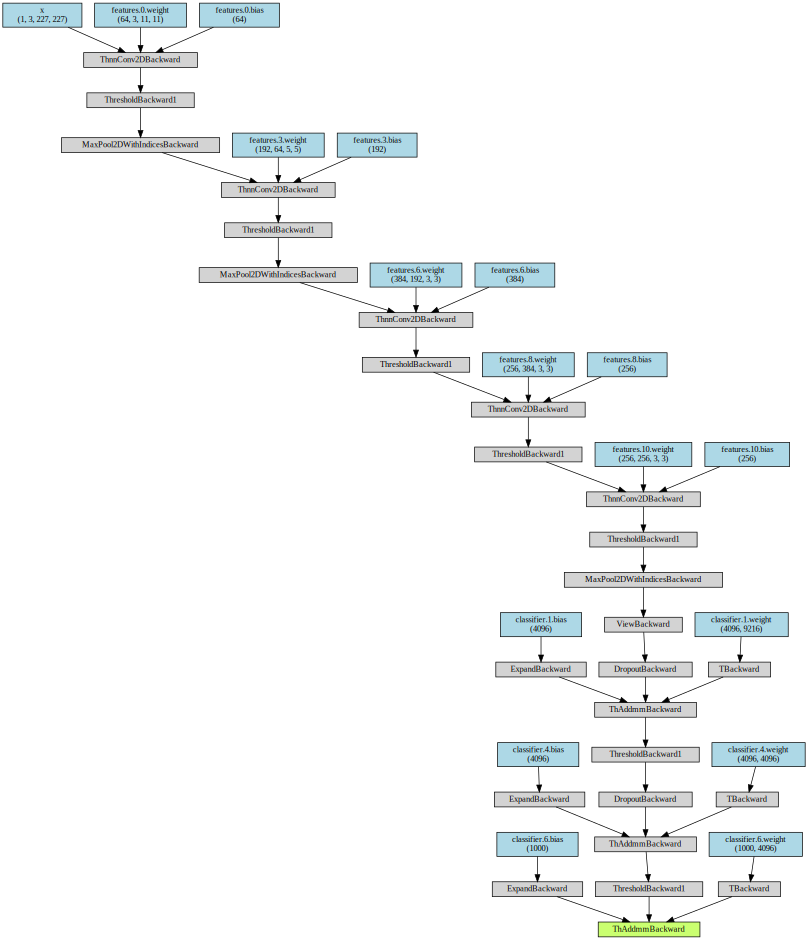

In [5]:
from torchviz import make_dot, make_dot_from_trace

from torchvision.models import AlexNet

model = AlexNet()

x = torch.randn(1, 3, 227, 227).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))



In [7]:
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-a9s3czi8
  Running setup.py bdist_wheel for pytorchviz ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-h9wjr8lf/wheels/b9/b9/85/ef34936f58754cb23840fd869be1367b5d525e29915a2a4fe9
Successfully built pytorchviz
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!sudo apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-compiler-10-0 cuda-cublas-10-0
  cuda-cublas-dev-10-0 cuda-cudart-10-0 cuda-cudart-dev-10-0 cuda-cufft-10-0
  cuda-cufft-dev-10-0 cuda-cuobjdump-10-0 cuda-cupti-10-0 cuda-curand-10-0
  cuda-curand-dev-10-0 cuda-cusolver-10-0 cuda-cusolver-dev-10-0
  cuda-cusparse-10-0 cuda-cusparse-dev-10-0 cuda-documentation-10-0
  cuda-driver-dev-10-0 cuda-gdb-10-0 cuda-gpu-library-advisor-10-0
  cuda-libraries-10-0 cuda-libraries-dev-10-0 cuda-license-10-0
  cuda-memcheck-10-0 cuda-misc-headers-10-0 cuda-npp-10-0 cuda-npp-dev-10-0
  cuda-nsight-10-0 cuda-nsight-compute-10-0 cuda-nvcc-10-0 cuda-nvdisasm-10-0
  cuda-nvgraph-10-0 cuda-nvgraph-dev-10-0 cuda-nvjpeg-10-0
  cuda-nvjpeg-dev-10-0 cuda-nvml-dev-10-0 cuda-nvprof-10-0 cuda-nvprune-10-0
  cuda-nvrtc-10-0 cuda-nvrtc-dev-10-0 cuda-nvtx-10-

In [3]:
from torchviz import make_dot, make_dot_from_trace


model = CNN3D().cuda()

x = torch.randn(1,10, 128,128,3).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))



NameError: name 'F' is not defined